In [196]:
# Setup:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics.classification import BinaryAUROC
from xgboost import XGBClassifier

In [197]:
test_set = pd.read_csv('/Users/sanzhar123/Downloads/test.csv')
training_set = pd.read_csv('/Users/sanzhar123/Downloads/train.csv')

In [199]:
means = None
stdevs = None

# Define preprocessing transform
def conversion_transform(df, is_test = False):
    # drop text columns
    new_df = df.drop(columns=['track_href', 'uri', 'type', 'analysis_url'])

    if is_test == True:
        new_df = new_df.drop(columns=['ID'])

    # Handle dates 
    date_column = new_df["track_album_release_date"].astype(str)

    parsed = pd.to_datetime(date_column, format='%Y-%m-%d', errors='coerce')
    new_df["year"] = parsed.dt.year
    new_df["month"] = parsed.dt.month
    new_df["day"] = parsed.dt.day

    # For year-only dates, extract year and default month/day to 1
    year_only_mask = new_df["year"].isna()
    new_df.loc[year_only_mask, "year"] = pd.to_numeric(date_column[year_only_mask], errors='coerce')
    new_df.loc[year_only_mask, "month"] = 1
    new_df.loc[year_only_mask, "day"] = 1

    new_df = new_df.drop(columns='track_album_release_date')

    if is_test == False:
        # Binarization of the output
        column_names = list(new_df.columns.values)
        column_names.append(column_names.pop(column_names.index('Popularity_Type')))
        new_df = new_df[column_names]

        lb = LabelBinarizer()
        new_df['Popularity_Type'] = lb.fit_transform(new_df['Popularity_Type'])

    # replace all the nan values with zero
    new_df = new_df.fillna(0)

    return new_df

def normalization_transform(df, is_test = False):
    # normalize data
    new_df = df.copy()
    if is_test == False:
        new_df.iloc[:, :-1] -= means
        new_df.iloc[:, :-1] /= stdevs
    else: 
        new_df = new_df[feature_columns]
        new_df -= means
        new_df /= stdevs
    return new_df

def preprocessing(df, is_test= False):
    new_df = conversion_transform(df, is_test)
    new_df = normalization_transform(new_df, is_test)
    return new_df

# compute normalization mean and stdev
filtered_training = conversion_transform(training_set)
means = np.mean(filtered_training.iloc[:, :-1], axis=0)
stdevs = np.std(filtered_training.iloc[:, :-1], axis=0)
feature_columns = list(filtered_training.columns[:-1])

filtered_training = preprocessing(training_set)

# Save IDs
test_IDs = test_set['ID'].values

In [200]:
# Music Dataloader
class MusicDataset(Dataset):
    """Music dataset."""

    def __init__(self, dataset, is_test, transform=None):
        """
        Arguments:
            dataset: Pandas dataframe
            transform: Transformation to data
        """

        data = dataset
        if transform:
            data = transform(dataset, is_test)

        # If it's the test set, there are no labels 
        if is_test:
            self.X = torch.tensor( data.values, dtype=torch.float32)
            self.y = None

        else:
        # example: last column is label, rest are features
            self.X = torch.tensor(
                data.iloc[:, :-1].values,
                dtype=torch.float32
            )
            self.y = torch.tensor(
                data.iloc[:, -1].values,
                dtype=torch.long
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [201]:
num_features = filtered_training.shape[1]-1
neuralnet = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(128, 32),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(32,1),
    nn.Sigmoid()
)

In [202]:
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=5*1e-4)
loss_fn = nn.BCELoss()

In [203]:
# split and load the data 
dataset = MusicDataset(training_set, is_test=False, transform=preprocessing)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
split_sizes = [train_size, test_size]

train_dataset, test_dataset = random_split(dataset, split_sizes, generator=torch.Generator().manual_seed(42))

training_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testing_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [204]:
def evaluate(model, dataset):
    # Switch to the evaluation mode: 
    model.eval()
    auroc_metric = BinaryAUROC(thresholds=None)

    # Compute the predictions and compare to the true labels
    pred = model(dataset.dataset.X[dataset.indices])
    auroc_metric.update(pred, dataset.dataset.y[dataset.indices])
    acc = auroc_metric.compute().numpy().item()
    model.train() 
    
    return acc

In [205]:
neuralnet.train()
train_error = []
test_error = []

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(training_data_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = neuralnet(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target.float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
    train_error.append(evaluate(neuralnet, train_dataset))
    print('Accuracy on the training set is', evaluate(neuralnet, train_dataset))
    test_error.append(evaluate(neuralnet, test_dataset))
    print('Accuracy on the testing set is', evaluate(neuralnet, test_dataset))

Train Epoch: 1  Loss: 0.4521
Accuracy on the training set is 0.7429733276367188
Accuracy on the testing set is 0.7263647317886353
Train Epoch: 2  Loss: 0.5468
Accuracy on the training set is 0.7680354118347168
Accuracy on the testing set is 0.7557132244110107
Train Epoch: 3  Loss: 0.3970
Accuracy on the training set is 0.7863963842391968
Accuracy on the testing set is 0.7866337299346924
Train Epoch: 4  Loss: 0.5563
Accuracy on the training set is 0.7950412034988403
Accuracy on the testing set is 0.7827927470207214
Train Epoch: 5  Loss: 0.5998
Accuracy on the training set is 0.802232027053833
Accuracy on the testing set is 0.7959099411964417
Train Epoch: 6  Loss: 0.5005
Accuracy on the training set is 0.8091171979904175
Accuracy on the testing set is 0.7956874370574951
Train Epoch: 7  Loss: 0.6195
Accuracy on the training set is 0.813174843788147
Accuracy on the testing set is 0.7994171380996704
Train Epoch: 8  Loss: 0.5031
Accuracy on the training set is 0.8159130811691284
Accuracy on 

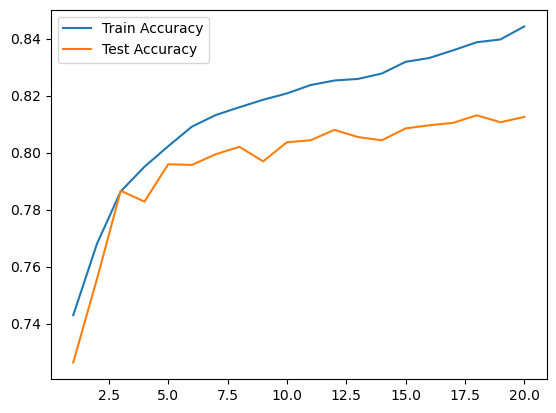

In [207]:
epochs = np.linspace(1,20, 20)
plt.plot(epochs, train_error, label = 'Train Accuracy')
plt.plot(epochs, test_error, label = 'Test Accuracy')
plt.legend()

In [208]:
# Now let's produce the output on the test_set 
torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

neuralnet.eval()
with torch.no_grad():
    predictions = 1 - neuralnet(torch_test.X).squeeze().numpy() # apparently the predictions are flipped lol

submission = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': predictions
})
submission.to_csv('submission.csv', index=False)

In [223]:
### Now let's train an XGboost and/or Random Forest Model

dataset = MusicDataset(training_set, is_test= False, transform=preprocessing)
X_np = dataset.X.numpy()
y_np = dataset.y.numpy()

torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

X_test_np = torch_test.X.numpy()

# X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size= 0.15, random_state=37)
XGboost = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 6)
XGboost.fit(X_np, y_np)
y_pred = XGboost.predict_proba(X_test_np)[:,1]

In [229]:
1-y_pred[:10]

array([0.34583813, 0.31419057, 0.58130705, 0.9568137 , 0.08758724,
       0.00156718, 0.21464175, 0.14924097, 0.9778215 , 0.614468  ],
      dtype=float32)

In [230]:
predictions[:10]

array([0.5049896 , 0.37660068, 0.66286814, 0.8719222 , 0.26890814,
       0.20900744, 0.28028017, 0.48895043, 0.76278037, 0.44011247],
      dtype=float32)

In [231]:
# Average the prediction of a Neural Net and XGboost 
y_final = (predictions + (1-y_pred))/2

submission2 = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': y_final
})
submission2.to_csv('submission2.csv', index=False)

In [ ]:
# rfc_clf = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=150)
# rfc_clf.fit(X_train, y_train)
# y_pred = rfc_clf.predict(X_test)
# acc = accuracy_score(y_pred, y_test)
# print(acc)

0.7706896551724138
